In [109]:
import os
import time
from dataclasses import dataclass

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tqdm.notebook import tqdm

### Set seeds for reproducibility

In [110]:
np.random.seed(42)
tf.random.set_seed(42)


### Check for GPU availability

In [111]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Using GPU: {gpus}")
else:
    print("Using CPU")


Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [112]:
lob_features = [
    "b0p", "b1p", "b2p", "b3p", "b4p", "b5p", "b6p", "b7p", "b8p", "b9p",
    "b0q", "b1q", "b2q", "b3q", "b4q", "b5q", "b6q", "b7q", "b8q", "b9q",
    "a0p", "a1p", "a2p", "a3p", "a4p", "a5p", "a6p", "a7p", "a8p", "a9p",
    "a0q", "a1q", "a2q", "a3q", "a4q", "a5q", "a6q", "a7q", "a8q", "a9q"
]

In [113]:
@dataclass
class Config:
    z_dim = 40*100  # Dimension of random noise
    batch_size = 64
    learning_rate_g = 0.0002
    learning_rate_d = 0.0002
    epochs = 100
    penalty_weight = 5
    sample_size = 100000

config = Config()

### Load and preprocess LOB data


In [114]:
file_path = "E:\DSA5204 Project\DSA5204-Group-9\lob\BTCUSDT-lob.parq"
df = pd.read_parquet(file_path, engine="pyarrow")

print(f"The legnth for the dataframe is {len(df)}")

The legnth for the dataframe is 189760


In [115]:
df = df.dropna(subset=lob_features).sample(n=config.sample_size, random_state=42)

In [116]:
scaler = MinMaxScaler()
lob_data = scaler.fit_transform(df[lob_features].values).astype(np.float32) #(5000, 40)
lob_dataset = tf.data.Dataset.from_tensor_slices(lob_data).batch(config.batch_size)


In [117]:
for batch in lob_dataset.take(1):
    print(f"Dimension of lob_dataset: {batch.shape}")

Dimension of lob_dataset: (64, 40)


### Generator

In [118]:
class Generator(models.Model):
    """Simple Generator that transforms noise into a 40-dimensional feature vector with financial constraints"""
    def __init__(self, config):
        super(Generator, self).__init__()
        self.config = config
        self.z_dim = config.z_dim

        self.dense1 = layers.Dense(1024, use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.leaky1 = layers.LeakyReLU(alpha=0.2)
        
        self.dense2 = layers.Dense(512, use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.leaky2 = layers.LeakyReLU(alpha=0.2)
        
        self.dense3 = layers.Dense(256, use_bias=False)
        self.bn3 = layers.BatchNormalization()
        self.leaky3 = layers.LeakyReLU(alpha=0.2)

        self.dense4 = layers.Dense(128, use_bias=False)
        self.bn4 = layers.BatchNormalization()
        self.leaky4 = layers.LeakyReLU(alpha=0.2)

        self.dense5 = layers.Dense(64, use_bias=False)
        self.bn5 = layers.BatchNormalization()
        self.leaky5 = layers.LeakyReLU(alpha=0.2)

        self.output_layer = layers.Dense(40, activation='tanh')

    def call(self, inputs, training=True):
        x = self.dense1(inputs)
        x = self.bn1(x, training=training)
        x = self.leaky1(x)
        
        x = self.dense2(x)
        x = self.bn2(x, training=training)
        x = self.leaky2(x)
        
        x = self.dense3(x)
        x = self.bn3(x, training=training)
        x = self.leaky3(x)
        
        x = self.dense4(x)
        x = self.bn4(x, training=training)
        x = self.leaky4(x)
        
        x = self.dense5(x)
        x = self.bn5(x, training=training)
        x = self.leaky5(x)
        
        lob_output = self.output_layer(x)

        return lob_output

### Minibatch Discriminator

In [119]:
# Minibatch Discrimination code
class MinibatchDiscrimination(layers.Layer):
    """Minibatch discrimination layer to prevent mode collapse"""

    def __init__(self, num_kernels=100, dim_per_kernel=5, **kwargs):
        super(MinibatchDiscrimination, self).__init__(**kwargs)
        self.num_kernels = num_kernels
        self.dim_per_kernel = dim_per_kernel

    def build(self, input_shape):
        #Defines a trainable weight (self.kernel) of shape (input_dim, num_kernels, dim_per_kernel)
        self.input_dim = input_shape[1] #Stores the number of features in the input tensor.
        kernel_shape = (self.input_dim, self.num_kernels, self.dim_per_kernel) #Shape of the kernel tensor
        initializer = tf.random_normal_initializer(stddev=0.02)
        self.kernel = self.add_weight(
            shape=kernel_shape,
            initializer=initializer,
            name='kernel',
            trainable=True
        )
        super(MinibatchDiscrimination, self).build(input_shape)

    def call(self, inputs, **kwargs):
        #Computes a projection of inputs using self.kernel.
        #If inputs has shape (batch_size, input_dim),
        #And kernel has shape (input_dim, num_kernels, dim_per_kernel),
        #Then activation will have shape (batch_size, num_kernels, dim_per_kernel).
        #Got from dot product.
        activation = tf.tensordot(inputs, self.kernel, axes=[[1], [0]])
        
        #Expands dimensions to compare all batch samples.
        expanded_act = tf.expand_dims(activation, 3)
        transposed_act = tf.expand_dims(tf.transpose(activation, [1, 2, 0]), 0)

        diff = expanded_act - transposed_act #
        abs_diff = tf.reduce_sum(tf.abs(diff), 2) #Computes the absolute differences between all pairs of samples.

        #Apply mask to avoid comparing a sample with itself.
        batch_size = tf.shape(inputs)[0]
        mask = 1.0 - tf.eye(batch_size) 
        #Creates an identity matrix (tf.eye(batch_size)), which has 1s on the diagonal and subtracts it from 1.0. Ensures that the diagonal is 0.
        mask = tf.expand_dims(mask, 1)

        #Expands dimensions to match abs_diff.
        if mask.shape.ndims != abs_diff.shape.ndims:
            mask = tf.reshape(mask, [-1, mask.shape[1], batch_size])

        exp = tf.exp(-abs_diff) * mask
        minibatch_features = tf.reduce_sum(exp, 2)

        return tf.concat([inputs, minibatch_features], axis=1)

The final shape is (batch_size, input_dim + num_kernels).

### Discriminator

No batch normalization for discriminator as BatchNorm normalizes across the batch, which may leak information between examples.

In [120]:
class Discriminator(models.Model):
    """Simple Discriminator for classifying real vs fake feature vectors with financial constraints"""
    def __init__(self, config, use_minibatch_discrimination=False):
        super(Discriminator, self).__init__()
        self.config = config
        self.use_minibatch_discrimination = use_minibatch_discrimination  # Store the flag
        
        self.dense1 = layers.Dense(512, input_shape=(40,))
        self.leaky1 = layers.LeakyReLU(alpha=0.2)
        
        self.dense2 = layers.Dense(256)
        self.leaky2 = layers.LeakyReLU(alpha=0.2)
        
        # Add Minibatch Discrimination layer
        if use_minibatch_discrimination:
             self.minibatch_layer = MinibatchDiscrimination(num_kernels=100, dim_per_kernel=5)
             
        self.dense3 = layers.Dense(128)
        self.leaky3 = layers.LeakyReLU(alpha=0.2)
        
        self.dense4 = layers.Dense(64)
        self.leaky4 = layers.LeakyReLU(alpha=0.2)
        
        self.output_layer = layers.Dense(1)
    
    
    def call(self, inputs, training=True):
        
        x = self.dense1(inputs)
        x = self.leaky1(x)
        
        x = self.dense2(x)
        x = self.leaky2(x)
        
        # Apply minibatch discrimination if enabled
        if self.use_minibatch_discrimination:
            x = self.minibatch_layer(x)
        x = self.dense3(x)
        x = self.leaky3(x)
        
        x = self.dense4(x)
        x = self.leaky4(x)
        
        output = self.output_layer(x)
        
        return output

In [121]:
class SimpleGAN:
    """Simplest GAN using a Generator and a Discriminator.
       Both models do not include any explicit penalty terms.
       Optionally enables minibatch discrimination in the discriminator.
    """
    def __init__(self, config, use_minibatch_discrimination=False):
        self.config = config
        
        # Instantiate the generator and discriminator
        self.generator = Generator(config)  # Assumes Generator is already modified similarly
        self.discriminator = Discriminator(config, use_minibatch_discrimination=use_minibatch_discrimination)
        
        self.gen_optimizer = tf.keras.optimizers.Adam(config.learning_rate_g)
        self.disc_optimizer = tf.keras.optimizers.Adam(config.learning_rate_d)
        
        self.fixed_noise = tf.random.normal([16, config.z_dim])
    
    def generator_loss(self, fake_output):
        # Generator adversarial loss: generator tries to fool the discriminator.
        target = tf.ones_like(fake_output)
        adv_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(target, fake_output, from_logits=True))
        return adv_loss
    
    def discriminator_loss(self, real_output, fake_output):
        real_labels = tf.ones_like(real_output)
        fake_labels = tf.zeros_like(fake_output)
        real_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_labels, real_output, from_logits=True))
        fake_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(fake_labels, fake_output, from_logits=True))
        return real_loss + fake_loss
    
    @tf.function
    def train_step(self, real_matrices):
        batch_size = tf.shape(real_matrices)[0]
        noise = tf.random.normal([batch_size, self.config.z_dim])
        
        # Update discriminator
        with tf.GradientTape() as disc_tape:
            # Generator now returns only generated samples (no penalty term)
            fake_matrices = self.generator(noise, training=True)
            real_output = self.discriminator(real_matrices, training=True)
            fake_output = self.discriminator(fake_matrices, training=True)
            disc_loss = self.discriminator_loss(real_output, fake_output)
        
        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))
        
        # Update generator
        with tf.GradientTape() as gen_tape:
            fake_matrices = self.generator(noise, training=True)
            fake_output = self.discriminator(fake_matrices, training=True)
            gen_loss = self.generator_loss(fake_output)
        
        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))
        
        return {"gen_loss": gen_loss, "disc_loss": disc_loss}
    
    def train(self, dataset, epochs):
        for epoch in range(epochs):
            for batch in dataset:
                metrics = self.train_step(batch)
            print(f"Epoch {epoch+1}/{epochs} - Generator Loss: {metrics['gen_loss']:.4f}, Discriminator Loss: {metrics['disc_loss']:.4f}")



### Reasonability Check functions:

In [122]:
def compute_faulty_rate(lob_tensor):
    """Calculates the faulty rate for synthetic LOB data using TensorFlow tensors."""
    
    bid_prices = lob_tensor[:, :10]  # First 10 columns are bid prices
    ask_prices = lob_tensor[:, 20:30]  # Columns 20-30 are ask prices
    bid_quantities = lob_tensor[:, 10:20]  # Columns 10-20 are bid quantities
    ask_quantities = lob_tensor[:, 30:40]  # Columns 30-40 are ask quantities

    faulty_count = tf.zeros(1, dtype=tf.float32)  # Initialize faulty count

    # 1. Ensure best bid price < best ask price (b0p < a0p)
    max_bid = tf.reduce_max(bid_prices, axis=1)  # Get the highest bid
    min_ask = tf.reduce_min(ask_prices, axis=1)  # Get the lowest ask
    faulty_count += tf.reduce_sum(tf.cast(max_bid >= min_ask, tf.float32))  # Count violations

    # 2. Bid prices should be in descending order (b0p > b1p > ...)
    faulty_count += tf.reduce_sum(tf.cast(tf.experimental.numpy.diff(bid_prices, axis=1) >= 0, tf.float32))

    # 3. Ask prices should be in ascending order (a0p < a1p < ...)
    faulty_count += tf.reduce_sum(tf.cast(tf.experimental.numpy.diff(ask_prices, axis=1) <= 0, tf.float32))

    # 4. Bid and ask quantities should be non-negative
    faulty_count += tf.reduce_sum(tf.cast(bid_quantities < 0, tf.float32))
    faulty_count += tf.reduce_sum(tf.cast(ask_quantities < 0, tf.float32))
    faulty_count += tf.reduce_sum(tf.cast(bid_prices < 0, tf.float32))
    faulty_count += tf.reduce_sum(tf.cast(ask_prices < 0, tf.float32))

    # Compute faulty rate as a percentage of all elements
    total_elements = tf.size(lob_tensor, out_type=tf.float32)
    faulty_rate = faulty_count / total_elements  # Returns a TensorFlow tensor
    
    # Count of Quantities with negative signs:
    neg_qty_count_bid = tf.reduce_sum(tf.cast(bid_quantities < 0, tf.int32))
    neg_qty_count_ask = tf.reduce_sum(tf.cast(ask_quantities < 0, tf.int32))
    
    # Sum of quantities with negative signs:
    neg_qty_sum_bid = tf.reduce_sum(tf.where(bid_quantities < 0, bid_quantities, tf.zeros_like(bid_quantities)))
    neg_qty_sum_ask = tf.reduce_sum(tf.where(ask_quantities < 0, ask_quantities, tf.zeros_like(ask_quantities)))
    
    # Difference between consecutiver bid and ask prices, shape (batch, 9)
    bid_diff = tf.experimental.numpy.diff(bid_prices, axis=1)
    ask_diff = tf.experimental.numpy.diff(ask_prices, axis=1)
    
    # Count of pricess lower than previous price:
    bid_lower_prev_count = tf.reduce_sum(tf.cast(bid_diff < 0, tf.int32))
    ask_lower_prev_count = tf.reduce_sum(tf.cast(ask_diff < 0, tf.int32))
    lower_prev_count = bid_lower_prev_count + ask_lower_prev_count
    
    # Count of prices higher than the next price: 
    bid_higher_next_count = tf.reduce_sum(tf.cast(bid_diff > 0, tf.int32))
    ask_higher_next_count = tf.reduce_sum(tf.cast(ask_diff > 0, tf.int32))
    higher_next_count = bid_higher_next_count + ask_higher_next_count
    
    # sum of max(0, price[i+1] - price[i]) 
    bid_diff_positive_sum = tf.reduce_sum(tf.maximum(0.0, bid_diff))
    ask_diff_positive_sum = tf.reduce_sum(tf.maximum(0.0, ask_diff))
    diff_positive_sum = bid_diff_positive_sum + ask_diff_positive_sum
    
    # sum of max(0, price[i] - price[i+1])
    bid_diff_negative_sum = tf.reduce_sum(tf.maximum(0.0, -bid_diff))
    ask_diff_negative_sum = tf.reduce_sum(tf.maximum(0.0, -ask_diff))
    diff_negative_sum = bid_diff_negative_sum + ask_diff_negative_sum

    return (
        float(faulty_rate.numpy().item()),
        int(neg_qty_count_bid.numpy().item()),
        int(neg_qty_count_ask.numpy().item()),
        float(neg_qty_sum_bid.numpy().item()),
        float(neg_qty_sum_ask.numpy().item()),
        int(lower_prev_count.numpy().item()),
        int(higher_next_count.numpy().item()),
        float(diff_positive_sum.numpy().item()),
        float(diff_negative_sum.numpy().item())
    )


# def plot_order_book_scatter(lob_sample):
#     """Scatter plot of a single LOB snapshot with price vs. quantity and level labels."""

#     # Extract bid and ask prices and sizes
#     bid_prices = np.array(lob_sample[:10])
#     bid_sizes = np.array(lob_sample[10:20])
#     ask_prices = np.array(lob_sample[20:30])
#     ask_sizes = np.array(lob_sample[30:40])

#     # Remove negative or zero values to ensure valid plotting
#     valid_bids = bid_sizes > 0
#     valid_asks = ask_sizes > 0
#     bid_prices, bid_sizes = bid_prices[valid_bids], bid_sizes[valid_bids]
#     ask_prices, ask_sizes = ask_prices[valid_asks], ask_sizes[valid_asks]

#     plt.figure(figsize=(8, 5))

#     # Scatter plot for bids and asks
#     plt.scatter(bid_sizes, bid_prices, color='blue', label="Bids", alpha=0.6)
#     plt.scatter(ask_sizes, ask_prices, color='red', label="Asks", alpha=0.6)

#     # Annotate each price level with its index
#     for i, (q, p) in enumerate(zip(bid_sizes, bid_prices)):
#         plt.annotate(f"b{i}", (q, p), fontsize=10, color='blue', ha="right")
    
#     for i, (q, p) in enumerate(zip(ask_sizes, ask_prices)):
#         plt.annotate(f"a{i}", (q, p), fontsize=10, color='red', ha="left")

#     # Adjust x-axis and y-axis dynamically
#     max_quantity = max(np.max(bid_sizes) if len(bid_sizes) > 0 else 0,
#                        np.max(ask_sizes) if len(ask_sizes) > 0 else 0) * 1.1
#     min_price = min(np.min(bid_prices) if len(bid_prices) > 0 else np.inf,
#                     np.min(ask_prices) if len(ask_prices) > 0 else np.inf) /1.1
#     max_price = max(np.max(bid_prices) if len(bid_prices) > 0 else -np.inf,
#                     np.max(ask_prices) if len(ask_prices) > 0 else -np.inf) *1.1

#     plt.xlim(0, max_quantity)
#     plt.ylim(min_price, max_price)

#     plt.xlabel("Quantity")
#     plt.ylabel("Price")
#     plt.title("LOB Scatter Plot (Price vs. Quantity)")

#     plt.legend()
#     plt.grid(True)
#     plt.show()

### Train normal

In [123]:
gan = SimpleGAN(config, use_minibatch_discrimination=False)

# Lists to store metrics per epoch
gen_loss_history = []
disc_loss_history = []
faulty_rate_history = []
neg_qty_count_history = []
neg_qty_sum_history = []
lower_prev_count_history = []
higher_next_count_history = []
diff_positive_sum_history = []
diff_negative_sum_history = []

# Modified training loop to record metrics per epoch
for epoch in range(config.epochs):
    epoch_gen_loss = 0.0
    epoch_disc_loss = 0.0
    num_batches = 0
    for batch in lob_dataset:
        metrics = gan.train_step(batch)
        epoch_gen_loss += metrics['gen_loss']
        epoch_disc_loss += metrics['disc_loss']
        num_batches += 1
    # Compute average losses for the epoch
    avg_gen_loss = epoch_gen_loss / num_batches
    avg_disc_loss = epoch_disc_loss / num_batches
    
    # Generate samples to compute the faulty rate at this epoch
    noise = tf.random.normal([100, config.z_dim])
    # After removing the penalty term, generator returns only the generated samples.
    generated_samples = gan.generator(noise, training=False)
    generated_samples = generated_samples.numpy()
    # Convert back to original scale using your scaler
    generated_samples = scaler.inverse_transform(generated_samples.reshape(100, -1))
    
    # Compute faulty metrics for each generated sample
    all_metrics = np.array([
        compute_faulty_rate(tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32))
        for sample in generated_samples
    ])
    
    avg_faulty_rate = np.mean(all_metrics[:, 0])
    avg_neg_qty_count = np.mean(all_metrics[:, 1] + all_metrics[:, 2])
    avg_neg_qty_sum = np.mean(all_metrics[:, 3] + all_metrics[:, 4])
    avg_lower_prev_count = np.mean(all_metrics[:, 5])
    avg_higher_next_count = np.mean(all_metrics[:, 6])
    avg_diff_positive_sum = np.mean(all_metrics[:, 7])
    avg_diff_negative_sum = np.mean(all_metrics[:, 8])
    
    # Record the metrics for this epoch
    gen_loss_history.append(avg_gen_loss)
    disc_loss_history.append(avg_disc_loss)
    faulty_rate_history.append(avg_faulty_rate)
    neg_qty_count_history.append(avg_neg_qty_count)
    neg_qty_sum_history.append(avg_neg_qty_sum)
    lower_prev_count_history.append(avg_lower_prev_count)
    higher_next_count_history.append(avg_higher_next_count)
    diff_positive_sum_history.append(avg_diff_positive_sum)
    diff_negative_sum_history.append(avg_diff_negative_sum)
    
    print(f"Epoch {epoch+1}/{config.epochs} - Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}, Faulty Rate: {avg_faulty_rate:.4f}")

# Create epochs array for plotting
epochs_arr = np.arange(1, config.epochs + 1)

# Plot 1: Faulty Rate only
plt.figure(figsize=(10, 6))
plt.plot(epochs_arr, faulty_rate_history, label="Faulty Rate", marker='o', color='red', alpha=0.9)
plt.xlabel("Epoch")
plt.ylabel("Faulty Rate")
plt.title("Faulty Rate Trend over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Negative Quantity Count only
plt.figure(figsize=(10, 6))
plt.plot(epochs_arr, neg_qty_count_history, label="Neg Qty Count", marker='o', color='orange', alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("Negative Quantity Count")
plt.title("Negative Quantity Count Trend over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Negative Quantity Sum only
plt.figure(figsize=(10, 6))
plt.plot(epochs_arr, neg_qty_sum_history, label="Neg Qty Sum", marker='o', color='purple', alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("Negative Quantity Sum")
plt.title("Negative Quantity Sum Trend over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot 4: Lower Prev Count and Higher Next Count together
plt.figure(figsize=(10, 6))
plt.plot(epochs_arr, lower_prev_count_history, label="Lower Prev Count", marker='o', color='brown', alpha=0.7)
plt.plot(epochs_arr, higher_next_count_history, label="Higher Next Count", marker='o', color='pink', alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("Count")
plt.title("Price Order Violations: Lower Prev & Higher Next Trends")
plt.legend()
plt.grid(True)
plt.show()

# Plot 5: Diff Positive Sum and Diff Negative Sum together
plt.figure(figsize=(10, 6))
plt.plot(epochs_arr, diff_positive_sum_history, label="Diff Positive Sum", marker='o', color='cyan', alpha=0.7)
plt.plot(epochs_arr, diff_negative_sum_history, label="Diff Negative Sum", marker='o', color='magenta', alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("Sum")
plt.title("Sum of Price Differences Trends over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Generate final samples for further evaluation/visualization
noise = tf.random.normal([100, config.z_dim])
generated_samples = gan.generator(noise, training=False)
generated_samples = generated_samples.numpy()
generated_samples = scaler.inverse_transform(generated_samples.reshape(100, -1))

# Plot histogram of faulty rates for final generated samples
faulty_rates = np.array([
    compute_faulty_rate(tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32))[0]
    for sample in generated_samples
])
plt.figure(figsize=(8, 5))
plt.hist(faulty_rates, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("Faulty Rate")
plt.ylabel("Frequency")
plt.title("Histogram of Faulty Rates in Generated LOB Data")
plt.grid(True)
plt.show()

# Save the first generated sample to CSV
single_lob_sample = generated_samples[0]
lob_columns = [
    "b0p", "b1p", "b2p", "b3p", "b4p", "b5p", "b6p", "b7p", "b8p", "b9p",
    "b0q", "b1q", "b2q", "b3q", "b4q", "b5q", "b6q", "b7q", "b8q", "b9q",
    "a0p", "a1p", "a2p", "a3p", "a4p", "a5p", "a6p", "a7p", "a8p", "a9p",
    "a0q", "a1q", "a2q", "a3q", "a4q", "a5q", "a6q", "a7q", "a8q", "a9q"
]
df_single_lob = pd.DataFrame([single_lob_sample], columns=lob_columns)
df_single_lob.to_csv("single_generated_lob.csv", index=False)
print("First sample saved to 'single_generated_lob.csv'")

# Plot order book scatter charts for the first 5 samples
# for i in range(5):
#     plot_order_book_scatter(generated_samples[i])

Epoch 1/100 - Gen Loss: 2.3231, Disc Loss: 0.9798, Faulty Rate: 0.4700
Epoch 2/100 - Gen Loss: 1.5466, Disc Loss: 1.0969, Faulty Rate: 0.4842
Epoch 3/100 - Gen Loss: 1.8307, Disc Loss: 1.0147, Faulty Rate: 0.5222
Epoch 4/100 - Gen Loss: 0.8150, Disc Loss: 1.3355, Faulty Rate: 0.6020
Epoch 5/100 - Gen Loss: 0.7335, Disc Loss: 1.3714, Faulty Rate: 0.4080


KeyboardInterrupt: 

### Testing Minibatch Discriminator

Epoch 1/20 - Gen Loss: 5.5766, Disc Loss: 0.0494, Faulty Rate: 0.4840
Epoch 2/20 - Gen Loss: 6.4169, Disc Loss: 0.0261, Faulty Rate: 0.4160
Epoch 3/20 - Gen Loss: 7.2497, Disc Loss: 0.0647, Faulty Rate: 0.5142
Epoch 4/20 - Gen Loss: 7.9883, Disc Loss: 0.1341, Faulty Rate: 0.4465
Epoch 5/20 - Gen Loss: 7.6564, Disc Loss: 0.2675, Faulty Rate: 0.3685
Epoch 6/20 - Gen Loss: 6.5647, Disc Loss: 0.2820, Faulty Rate: 0.5248
Epoch 7/20 - Gen Loss: 6.6902, Disc Loss: 0.2292, Faulty Rate: 0.4902
Epoch 8/20 - Gen Loss: 6.6969, Disc Loss: 0.3101, Faulty Rate: 0.4200
Epoch 9/20 - Gen Loss: 5.9072, Disc Loss: 0.2700, Faulty Rate: 0.4303
Epoch 10/20 - Gen Loss: 4.7424, Disc Loss: 0.3113, Faulty Rate: 0.4368
Epoch 11/20 - Gen Loss: 4.9319, Disc Loss: 0.2689, Faulty Rate: 0.4945
Epoch 12/20 - Gen Loss: 4.6825, Disc Loss: 0.3748, Faulty Rate: 0.5017
Epoch 13/20 - Gen Loss: 4.7440, Disc Loss: 0.3361, Faulty Rate: 0.4742
Epoch 14/20 - Gen Loss: 3.9934, Disc Loss: 0.5283, Faulty Rate: 0.4855
Epoch 15/20 - G

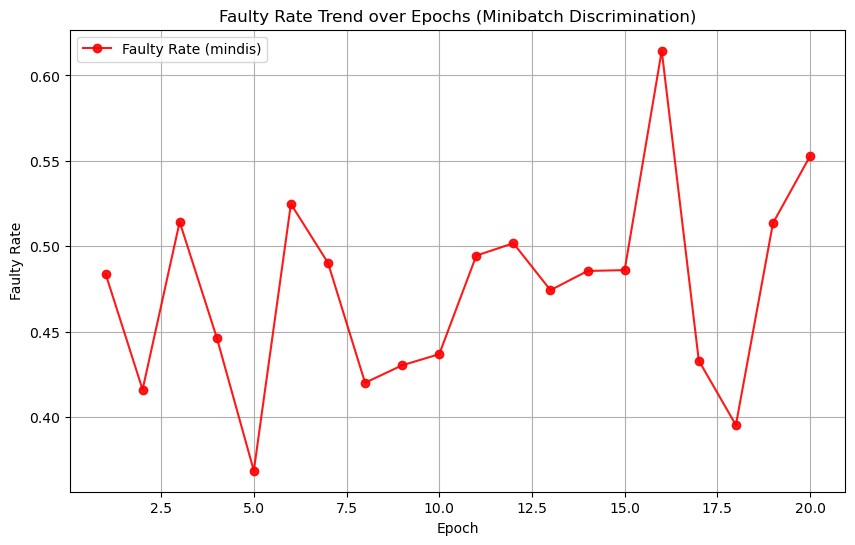

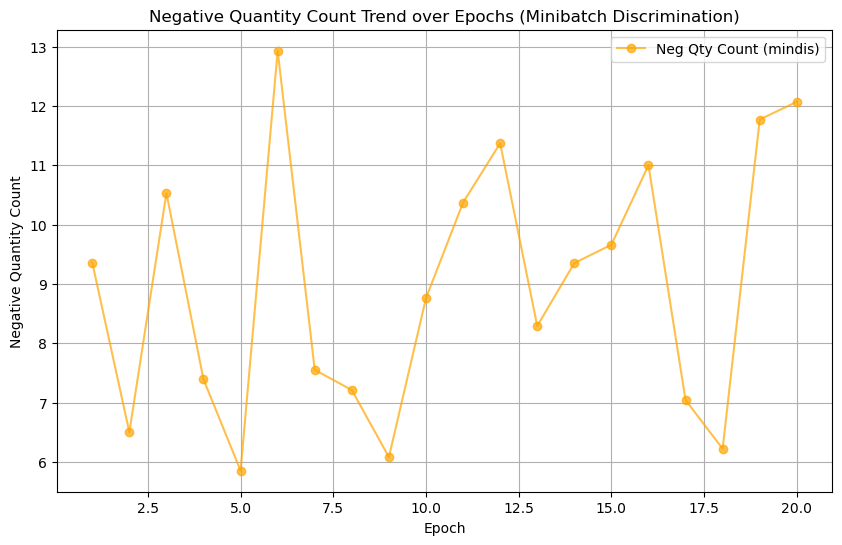

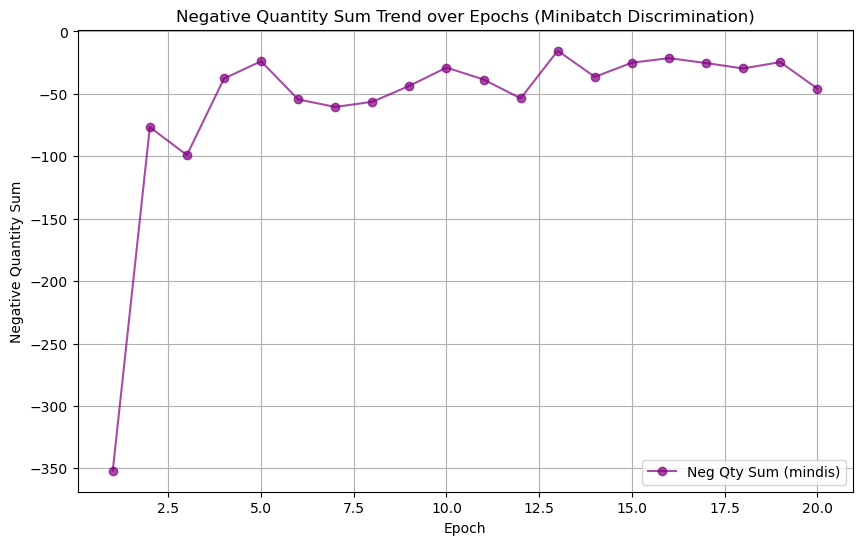

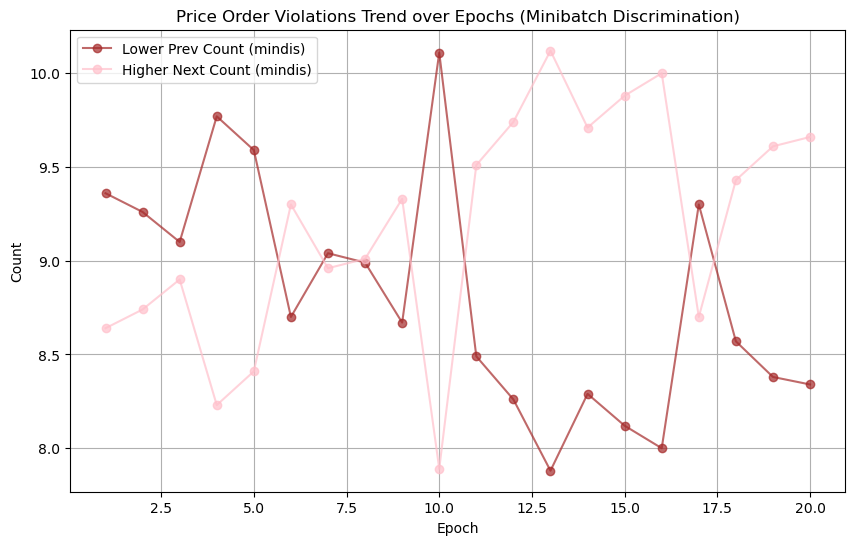

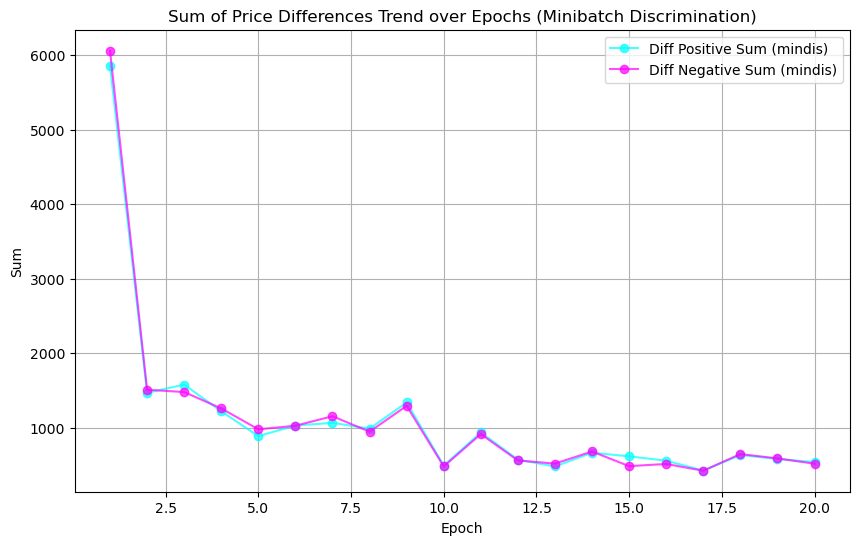

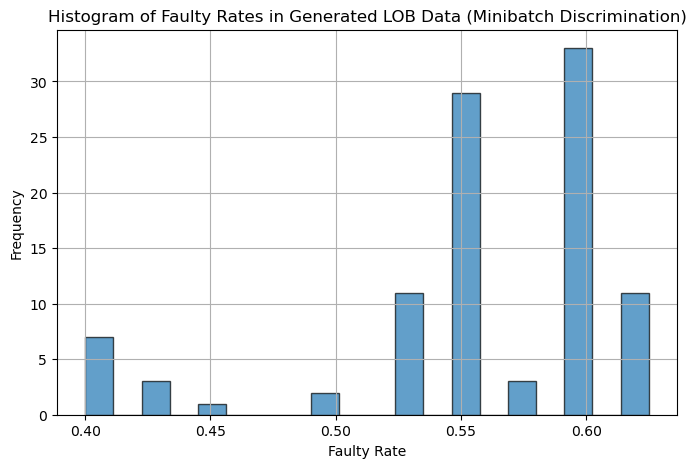

First sample saved to 'single_generated_lob_mindis.csv'


In [ ]:
# Instantiate your GAN with minibatch discrimination enabled
gan_mindis = SimpleGAN(config, use_minibatch_discrimination=True)

# Lists to store metrics per epoch for gan_mindis
gen_loss_mindis_history = []
disc_loss_mindis_history = []
faulty_rate_mindis_history = []
neg_qty_count_mindis_history = []
neg_qty_sum_mindis_history = []
lower_prev_count_mindis_history = []
higher_next_count_mindis_history = []
diff_positive_sum_mindis_history = []
diff_negative_sum_mindis_history = []

# Training loop for gan_mindis
for epoch in range(config.epochs):
    epoch_gen_loss_mindis = 0.0
    epoch_disc_loss_mindis = 0.0
    num_batches_mindis = 0
    for batch in lob_dataset:
        metrics_mindis = gan_mindis.train_step(batch)
        epoch_gen_loss_mindis += metrics_mindis['gen_loss']
        epoch_disc_loss_mindis += metrics_mindis['disc_loss']
        num_batches_mindis += 1
    # Compute average losses for the epoch
    avg_gen_loss_mindis = epoch_gen_loss_mindis / num_batches_mindis
    avg_disc_loss_mindis = epoch_disc_loss_mindis / num_batches_mindis
    
    # Generate samples to compute faulty metrics at this epoch
    noise_mindis = tf.random.normal([100, config.z_dim])
    generated_samples_mindis = gan_mindis.generator(noise_mindis, training=False)
    generated_samples_mindis = generated_samples_mindis.numpy()
    generated_samples_mindis = scaler.inverse_transform(generated_samples_mindis.reshape(100, -1))
    
    # Compute faulty metrics for each generated sample
    # The compute_faulty_rate function returns a tuple of 9 values:
    # (faulty_rate, neg_qty_count_bid, neg_qty_count_ask, neg_qty_sum_bid, neg_qty_sum_ask,
    #  lower_prev_count, higher_next_count, diff_positive_sum, diff_negative_sum)
    all_metrics_mindis = np.array([
        compute_faulty_rate(tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32))
        for sample in generated_samples_mindis
    ])
    
    avg_faulty_rate_mindis = np.mean(all_metrics_mindis[:, 0])
    avg_neg_qty_count_mindis = np.mean(all_metrics_mindis[:, 1] + all_metrics_mindis[:, 2])
    avg_neg_qty_sum_mindis = np.mean(all_metrics_mindis[:, 3] + all_metrics_mindis[:, 4])
    avg_lower_prev_count_mindis = np.mean(all_metrics_mindis[:, 5])
    avg_higher_next_count_mindis = np.mean(all_metrics_mindis[:, 6])
    avg_diff_positive_sum_mindis = np.mean(all_metrics_mindis[:, 7])
    avg_diff_negative_sum_mindis = np.mean(all_metrics_mindis[:, 8])
    
    # Record the metrics for this epoch
    gen_loss_mindis_history.append(avg_gen_loss_mindis)
    disc_loss_mindis_history.append(avg_disc_loss_mindis)
    faulty_rate_mindis_history.append(avg_faulty_rate_mindis)
    neg_qty_count_mindis_history.append(avg_neg_qty_count_mindis)
    neg_qty_sum_mindis_history.append(avg_neg_qty_sum_mindis)
    lower_prev_count_mindis_history.append(avg_lower_prev_count_mindis)
    higher_next_count_mindis_history.append(avg_higher_next_count_mindis)
    diff_positive_sum_mindis_history.append(avg_diff_positive_sum_mindis)
    diff_negative_sum_mindis_history.append(avg_diff_negative_sum_mindis)
    
    print(f"Epoch {epoch+1}/{config.epochs} - Gen Loss: {avg_gen_loss_mindis:.4f}, "
          f"Disc Loss: {avg_disc_loss_mindis:.4f}, Faulty Rate: {avg_faulty_rate_mindis:.4f}")

# Create epochs array for plotting
epochs_arr_mindis = np.arange(1, config.epochs + 1)

# Plot 1: Faulty Rate
plt.figure(figsize=(10, 6))
plt.plot(epochs_arr_mindis, faulty_rate_mindis_history, label="Faulty Rate (mindis)", marker='o', color='red', alpha=0.9)
plt.xlabel("Epoch")
plt.ylabel("Faulty Rate")
plt.title("Faulty Rate Trend over Epochs (Minibatch Discrimination)")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Negative Quantity Count
plt.figure(figsize=(10, 6))
plt.plot(epochs_arr_mindis, neg_qty_count_mindis_history, label="Neg Qty Count (mindis)", marker='o', color='orange', alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("Negative Quantity Count")
plt.title("Negative Quantity Count Trend over Epochs (Minibatch Discrimination)")
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Negative Quantity Sum
plt.figure(figsize=(10, 6))
plt.plot(epochs_arr_mindis, neg_qty_sum_mindis_history, label="Neg Qty Sum (mindis)", marker='o', color='purple', alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("Negative Quantity Sum")
plt.title("Negative Quantity Sum Trend over Epochs (Minibatch Discrimination)")
plt.legend()
plt.grid(True)
plt.show()

# Plot 4: Lower Prev Count and Higher Next Count
plt.figure(figsize=(10, 6))
plt.plot(epochs_arr_mindis, lower_prev_count_mindis_history, label="Lower Prev Count (mindis)", marker='o', color='brown', alpha=0.7)
plt.plot(epochs_arr_mindis, higher_next_count_mindis_history, label="Higher Next Count (mindis)", marker='o', color='pink', alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("Count")
plt.title("Price Order Violations Trend over Epochs (Minibatch Discrimination)")
plt.legend()
plt.grid(True)
plt.show()

# Plot 5: Diff Positive Sum and Diff Negative Sum
plt.figure(figsize=(10, 6))
plt.plot(epochs_arr_mindis, diff_positive_sum_mindis_history, label="Diff Positive Sum (mindis)", marker='o', color='cyan', alpha=0.7)
plt.plot(epochs_arr_mindis, diff_negative_sum_mindis_history, label="Diff Negative Sum (mindis)", marker='o', color='magenta', alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("Sum")
plt.title("Sum of Price Differences Trend over Epochs (Minibatch Discrimination)")
plt.legend()
plt.grid(True)
plt.show()

# Generate final samples for further evaluation/visualization from gan_mindis
noise_mindis_final = tf.random.normal([100, config.z_dim])
generated_samples_mindis_final = gan_mindis.generator(noise_mindis_final, training=False)
generated_samples_mindis_final = generated_samples_mindis_final.numpy()
generated_samples_mindis_final = scaler.inverse_transform(generated_samples_mindis_final.reshape(100, -1))

# Plot histogram of faulty rates for final generated samples from gan_mindis
faulty_rates_mindis_final = np.array([
    compute_faulty_rate(tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32))[0]
    for sample in generated_samples_mindis_final
])
plt.figure(figsize=(8, 5))
plt.hist(faulty_rates_mindis_final, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("Faulty Rate")
plt.ylabel("Frequency")
plt.title("Histogram of Faulty Rates in Generated LOB Data (Minibatch Discrimination)")
plt.grid(True)
plt.show()

# Save the first generated sample from gan_mindis to CSV
single_lob_sample_mindis = generated_samples_mindis_final[0]
lob_columns = [
    "b0p", "b1p", "b2p", "b3p", "b4p", "b5p", "b6p", "b7p", "b8p", "b9p",
    "b0q", "b1q", "b2q", "b3q", "b4q", "b5q", "b6q", "b7q", "b8q", "b9q",
    "a0p", "a1p", "a2p", "a3p", "a4p", "a5p", "a6p", "a7p", "a8p", "a9p",
    "a0q", "a1q", "a2q", "a3q", "a4q", "a5q", "a6q", "a7q", "a8q", "a9q"
]
df_single_lob_mindis = pd.DataFrame([single_lob_sample_mindis], columns=lob_columns)
df_single_lob_mindis.to_csv("single_generated_lob_mindis.csv", index=False)
print("First sample saved to 'single_generated_lob_mindis.csv'")